In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import GridSearchCV
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## Lets load the data

full_df_NO2 = pd.read_pickle("full_df_2021_NOX.pkl")
pd.set_option('display.max_columns', None)

## This the data cleaning. Keeping only the relevant features and removing the less than equal to zero target values

df1= full_df_NO2.drop(full_df_NO2.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1)
df1
df2 = df1.drop(df1.columns[[2,3,4,5,6,9]], axis=1) 
df2
j=[]
for i in range(4,72):
    j.append(i)
df3 = df2.drop(df2.columns[j], axis=1) 
df3

df4 = df3.drop(df3.columns[[11,12,13,14,15,16,17,18]], axis=1) 
df4 = df4.drop(df4.columns[6], axis=1) 

df4.rename(columns={'pda': 'Average Pupil Diameter (mm)', 'pup_dis': 'Pupil Distance (mm)','pd_diff': 'Difference in Pupil Diameter (mm)', 'ECG.': 'ECG (V)','Resp.': 'Respiration Rate (brpm)','Temp.': 'Skin Temperature ($\mathrm{^o C})$','HR': 'Heart Rate (bpm)','NO2':'$\mathrm{NO_2}$ (ppb)','SpO2':'$\mathrm{SpO_2}$ (%)','GSR':'GSR ($\mathrm{\mu S}$)'}, inplace=True)
df4
df_final = df4[df4['$\mathrm{NO_2}$ (ppb)'] >=0]


## Lets change some of variables to standard units

pd.options.mode.chained_assignment = None ## apparently this needs to be added to overcome an error i dont understand  

df_final['$\mathrm{SpO_2}$ (%)']=df_final['$\mathrm{SpO_2}$ (%)']*1000000 ## change the SpO2 to percentage
df_final['GSR ($\mathrm{\mu S}$)']=df_final['GSR ($\mathrm{\mu S}$)']*1000 ## convert kiloohms to ohms
df_final['GSR ($\mathrm{\mu S}$)']=1/df_final['GSR ($\mathrm{\mu S}$)']  ## convert ohms to siemans by taking the reciprocal
df_final['GSR ($\mathrm{\mu S}$)']=df_final['GSR ($\mathrm{\mu S}$)']*1000000 ## convert siemens to microsiemens
df_final

,$\mathrm{NO_2}$ (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$,Fp1-delta ($\mathrm{V^2}$/Hz),Fp2-delta ($\mathrm{V^2}$/Hz),F3-delta ($\mathrm{V^2}$/Hz),F4-delta ($\mathrm{V^2}$/Hz),C3-delta ($\mathrm{V^2}$/Hz),C4-delta ($\mathrm{V^2}$/Hz),P3-delta ($\mathrm{V^2}$/Hz),P4-delta ($\mathrm{V^2}$/Hz),O1-delta ($\mathrm{V^2}$/Hz),O2-delta ($\mathrm{V^2}$/Hz),F7-delta ($\mathrm{V^2}$/Hz),F8-delta ($\mathrm{V^2}$/Hz),T7-delta ($\mathrm{V^2}$/Hz),T8-delta ($\mathrm{V^2}$/Hz),P7-delta ($\mathrm{V^2}$/Hz),P8-delta ($\mathrm{V^2}$/Hz),Fz-delta ($\mathrm{V^2}$/Hz),Cz-delta ($\mathrm{V^2}$/Hz),Pz-delta ($\mathrm{V^2}$/Hz),Oz-delta ($\mathrm{V^2}$/Hz),FC1-delta ($\mathrm{V^2}$/Hz),FC2-delta ($\mathrm{V^2}$/Hz),CP1-delta ($\mathrm{V^2}$/Hz),CP2-delta ($\mathrm{V^2}$/Hz),FC5-delta ($\mathrm{V^2}$/Hz),FC6-delta ($\mathrm{V^2}$/Hz),CP5-delta ($\mathrm{V^2}$/Hz),CP6-delta ($\mathrm{V^2}$/Hz),FT9-delta ($\mathrm{V^2}$/Hz),FT10-delta ($\mathrm{V^2}$/Hz),FCz-delta ($\mathrm{V^2}$/Hz),AFz-delta ($\mathrm{V^2}$/Hz),F1-delta ($\mathrm{V^2}$/Hz),F2-delta ($\mathrm{V^2}$/Hz),C1-delta ($\mathrm{V^2}$/Hz),C2-delta ($\mathrm{V^2}$/Hz),P1-delta ($\mathrm{V^2}$/Hz),P2-delta ($\mathrm{V^2}$/Hz),AF3-delta ($\mathrm{V^2}$/Hz),AF4-delta ($\mathrm{V^2}$/Hz),FC3-delta ($\mathrm{V^2}$/Hz),FC4-delta ($\mathrm{V^2}$/Hz),CP3-delta ($\mathrm{V^2}$/Hz),CP4-delta ($\mathrm{V^2}$/Hz),PO3-delta ($\mathrm{V^2}$/Hz),PO4-delta ($\mathrm{V^2}$/Hz),F5-delta ($\mathrm{V^2}$/Hz),F6-delta ($\mathrm{V^2}$/Hz),C5-delta ($\mathrm{V^2}$/Hz),C6-delta ($\mathrm{V^2}$/Hz),P5-delta ($\mathrm{V^2}$/Hz),P6-delta ($\mathrm{V^2}$/Hz),AF7-delta ($\mathrm{V^2}$/Hz),AF8-delta ($\mathrm{V^2}$/Hz),FT7-delta ($\mathrm{V^2}$/Hz),FT8-delta ($\mathrm{V^2}$/Hz),TP7-delta ($\mathrm{V^2}$/Hz),TP8-delta ($\mathrm{V^2}$/Hz),PO7-delta ($\mathrm{V^2}$/Hz),PO8-delta ($\mathrm{V^2}$/Hz),Fpz-delta ($\mathrm{V^2}$/Hz),CPz-delta ($\mathrm{V^2}$/Hz),POz-delta ($\mathrm{V^2}$/Hz),TP10-delta ($\mathrm{V^2}$/Hz),Fp1-theta ($\mathrm{V^2}$/Hz),Fp2-theta ($\mathrm{V^2}$/Hz),F3-theta ($\mathrm{V^2}$/Hz),F4-theta ($\mathrm{V^2}$/Hz),C3-theta ($\mathrm{V^2}$/Hz),C4-theta ($\mathrm{V^2}$/Hz),P3-theta ($\mathrm{V^2}$/Hz),P4-theta ($\mathrm{V^2}$/Hz),O1-theta ($\mathrm{V^2}$/Hz),O2-theta ($\mathrm{V^2}$/Hz),F7-theta ($\mathrm{V^2}$/Hz),F8-theta ($\mathrm{V^2}$/Hz),T7-theta ($\mathrm{V^2}$/Hz),T8-theta ($\mathrm{V^2}$/Hz),P7-theta ($\mathrm{V^2}$/Hz),P8-theta ($\mathrm{V^2}$/Hz),Fz-theta ($\mathrm{V^2}$/Hz),Cz-theta ($\mathrm{V^2}$/Hz),Pz-theta ($\mathrm{V^2}$/Hz),Oz-theta ($\mathrm{V^2}$/Hz),FC1-theta ($\mathrm{V^2}$/Hz),FC2-theta ($\mathrm{V^2}$/Hz),CP1-theta ($\mathrm{V^2}$/Hz),CP2-theta ($\mathrm{V^2}$/Hz),FC5-theta ($\mathrm{V^2}$/Hz),FC6-theta ($\mathrm{V^2}$/Hz),CP5-theta ($\mathrm{V^2}$/Hz),CP6-theta ($\mathrm{V^2}$/Hz),FT9-theta ($\mathrm{V^2}$/Hz),FT10-theta ($\mathrm{V^2}$/Hz),FCz-theta ($\mathrm{V^2}$/Hz),AFz-theta ($\mathrm{V^2}$/Hz),F1-theta ($\mathrm{V^2}$/Hz),F2-theta ($\mathrm{V^2}$/Hz),C1-theta ($\mathrm{V^2}$/Hz),C2-theta ($\mathrm{V^2}$/Hz),P1-theta ($\mathrm{V^2}$/Hz),P2-theta ($\mathrm{V^2}$/Hz),AF3-theta ($\mathrm{V^2}$/Hz),AF4-theta ($\mathrm{V^2}$/Hz),FC3-theta ($\mathrm{V^2}$/Hz),FC4-theta ($\mathrm{V^2}$/Hz),CP3-theta ($\mathrm{V^2}$/Hz),CP4-theta ($\mathrm{V^2}$/Hz),PO3-theta ($\mathrm{V^2}$/Hz),PO4-theta ($\mathrm{V^2}$/Hz),F5-theta ($\mathrm{V^2}$/Hz),F6-theta ($\mathrm{V^2}$/Hz),C5-theta ($\mathrm{V^2}$/Hz),C6-theta ($\mathrm{V^2}$/Hz),P5-theta ($\mathrm{V^2}$/Hz),P6-theta ($\mathrm{V^2}$/Hz),AF7-theta ($\mathrm{V^2}$/Hz),AF8-theta ($\mathrm{V^2}$/Hz),FT7-theta ($\mathrm{V^2}$/Hz),FT8-theta ($\mathrm{V^2}$/Hz),TP7-theta ($\mathrm{V^2}$/Hz),TP8-theta ($\mathrm{V^2}$/Hz),PO7-theta ($\mathrm{V^2}$/Hz),PO8-theta ($\mathrm{V^2}$/Hz),Fpz-theta ($\mathrm{V^2}$/Hz),CPz-theta ($\mathrm{V^2}$/Hz),POz-theta ($\mathrm{V^2}$/Hz),TP10-theta ($\

In [3]:
## Lets create a Train-Test set and transform the data.
## Note that the training set is fit_transformed but test is only transformed

features=df_final.drop("$\mathrm{NO_2}$ (ppb)",axis=1)
target=df_final["$\mathrm{NO_2}$ (ppb)"].copy()

#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

In [4]:
## lets optimize the hyperparameters

param_grid=[{'n_estimators':[80,90,100,110,120], 'max_features':[180,200,240,250]},]

In [5]:
## Lets now train the model using Random Forest Regressor 

forest_reg=RandomForestRegressor(n_jobs=-1)
grid_search=GridSearchCV(forest_reg,param_grid,cv=3,scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'max_features': [180, 200, 240, 250],
                          'n_estimators': [80, 90, 100, 110, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [6]:
grid_search.best_estimator_

RandomForestRegressor(max_features=200, n_estimators=90, n_jobs=-1)

In [7]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [8]:
final_model.fit(X_train,y_train)

## The train prediction
train_prediction_RF=final_model.predict(X_train)
RF_mse=mean_squared_error(y_train,train_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_train=RF_rmse

print('The train RMSE for NO2 is:::', '%.2f' % RF_rmse_train)

The train RMSE for NO2 is::: 2.95


In [9]:
## The test prediction

test_prediction_RF=final_model.predict(X_test)
RF_mse=mean_squared_error(y_test,test_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_test=RF_rmse

print('The test RMSE for NO2 is:::', '%.2f' % RF_rmse_test)



The test RMSE for NO2 is::: 10.08


In [10]:
### The correlation values

#from scipy.stats import pearsonr

## The train correlation
train_r_sq=(pearsonr(y_train,train_prediction_RF)[0])**2
correlation_train=int(train_r_sq*100)/100 ## display only two digits without rounding
print(correlation_train)

## The test correlation
test_r_sq=(pearsonr(y_test,test_prediction_RF)[0])**2
correlation_test=int(test_r_sq*100)/100 ## display only two digits without rounding
print(correlation_test)

0.91
0.11


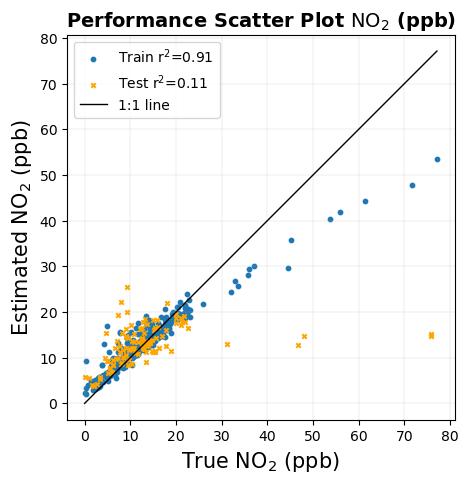

In [11]:
## Lets plot the scatter plot


import matplotlib as mpl

mpl.rcParams['mathtext.default']='regular'


plt.figure(figsize=(5,5))
plt.scatter(y_train, train_prediction_RF,s=10,c='C0',label="Train $r^2$={}".format(correlation_train))
plt.scatter(y_test, test_prediction_RF,marker='x',s=10,c='orange',label='Test $r^2$={}'.format(correlation_test))


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))
plt.plot([p1, p2], [p1, p2], 'black',label='1:1 line',linewidth=1)
plt.xlabel('True $\mathrm{NO_2}$ (ppb)', fontsize=15)
plt.ylabel('Estimated $\mathrm{NO_2}$ (ppb)', fontsize=15)
plt.axis('equal')
plt.title("Performance Scatter Plot $\mathrm{NO_2}$ (ppb)", fontsize=14,fontweight="bold")
plt.legend()
plt.grid(axis='both',linewidth=0.15)
plt.show()

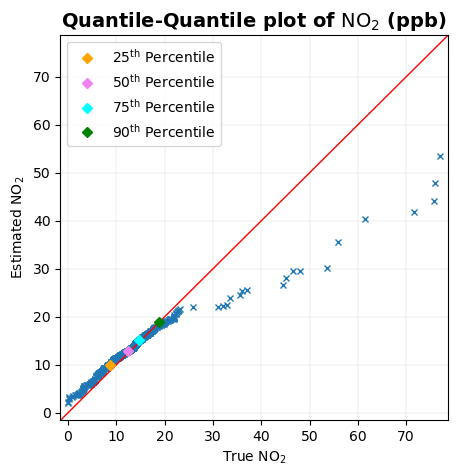

In [12]:
## Lets plot the quantile quantile 

all_preds=np.concatenate((train_prediction_RF,test_prediction_RF)) ## the list of all predictions and target values
preds=np.sort(all_preds)
tars=target.sort_values()

## This helps in customizing the graph
import statsmodels.api as sm
import scipy.stats as stats

plt.rc("figure", figsize=(5,5)) ## to make same figure size in statsmodels.api

pp_x = sm.ProbPlot(preds, fit=False)
pp_y = sm.ProbPlot(tars, fit=False)
qq = pp_x.qqplot(xlabel='True $\mathrm{NO_2}$',ylabel='Estimated $\mathrm{NO_2}$',marker='x',markersize=4,other=pp_y)

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1)
tars_25=np.percentile(tars,25)  ## for the percentiles                                                        
tars_50=np.percentile(tars,50)
tars_75=np.percentile(tars,75)
tars_90=np.percentile(tars,90)


preds_25=np.percentile(preds,25)
preds_50=np.percentile(preds,50)
preds_75=np.percentile(preds,75)  
preds_90=np.percentile(tars,90)  ## end of percentiles

plt.plot(tars_25,preds_25,marker="D",markersize=5,color="orange",linestyle ='None',label="$\mathrm{25^{th}}$ Percentile")
plt.plot(tars_50,preds_50,marker="D",markersize=5,color="violet",linestyle ='None',label="$\mathrm{50^{th}}$ Percentile")
plt.plot(tars_75,preds_75,marker="D",markersize=5,color="Cyan",linestyle ='None',label="$\mathrm{75^{th}}$ Percentile")
plt.plot(tars_90,preds_90,marker="D",markersize=5,color="Green",linestyle ='None',label="$\mathrm{90^{th}}$ Percentile")


plt.grid(axis='both',linewidth=0.15)

plt. title('Quantile-Quantile plot of $\mathrm{NO_2}$ (ppb) ',fontsize=14,fontweight="bold")

plt.legend()
plt.show()


## Note that since the number of samples is the same, sorting the values in ascending or descending order and then...
## plotting a scatter plot will also do the same thing as the quantiles are located in same point for distribution..
## of same size.

In [13]:
## Lets now plot the Time series plot. 

## Note that using the train_test_split function shuffles the data. so first the y_train and y_test has to be....
#concatenated. Dont use the "target" variable because the predicted values-train_prediction and train_prediction are not in
## in a timestamp but in an array.

splitted_original_data=pd.concat([y_train,y_test]) ## concatenate the splitted original target variable i.e. NO_2

predicted_splited=np.concatenate((train_prediction_RF,test_prediction_RF),axis=None) ## concatenate the predicted....

splitted_df=splitted_original_data.to_frame() ##convert splitted original data NO2 from pandas series to 


splitted_df['predicted_splited_NO2']=predicted_splited.tolist() ## Now concatenate the NO2 dataframe and the


sorted_df=splitted_df.sort_values(by='dateTime') ## sort according to timestamp

df_reset=sorted_df.reset_index() ##reset the index and start from zero as the hh:mm:ss is not real time
 

df_indexed=df_reset.drop(columns="dateTime") 


df_timeseries=df_indexed.rename(columns={'NO2':'True $\mathrm{NO_2}$','predicted_splited_NO2':'Estimated $\mathrm{NO_2}$'})
df_timeseries 

,$\mathrm{NO_2}$ (ppb),Estimated $\mathrm{NO_2}$
0,12.4,13.215556
1,12.6,12.886667
2,12.9,15.494444
3,13.1,13.201111
4,13.4,12.985556
...,...,...
577,16.4,16.684444
578,16.9,15.397778
579,14.9,12.823333
580,12.7,11.724444


In [14]:
## lets now extract rows from the timeseries so that there is discontinuity in the trials, as the red lines seen are...
## continous

timeseries_1=df_timeseries.iloc[0:135,:]
timeseries_2=df_timeseries.iloc[136:158,:]
timeseries_3=df_timeseries.iloc[159:284,:]
timeseries_4=df_timeseries.iloc[285:404,:]
timeseries_5=df_timeseries.iloc[405:536,:]
timeseries_6=df_timeseries.iloc[537:581,:]

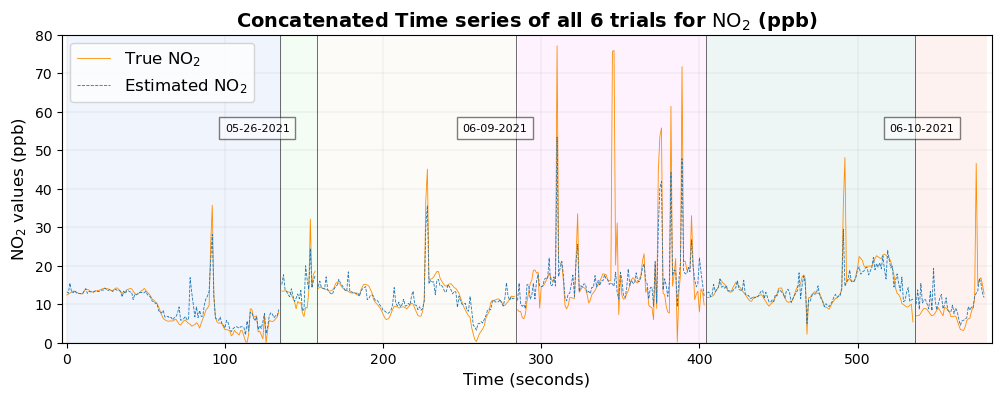

In [15]:
fig, ax = plt.subplots(figsize=(12,4))


ax.plot(timeseries_1['$\mathrm{NO_2}$ (ppb)'],label='True $\mathrm{NO_2}$',linewidth=0.6,color='darkorange')
ax.plot(timeseries_1['Estimated $\mathrm{NO_2}$'],label='Estimated $\mathrm{NO_2}$',linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_2['$\mathrm{NO_2}$ (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_2['Estimated $\mathrm{NO_2}$'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_3['$\mathrm{NO_2}$ (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_3['Estimated $\mathrm{NO_2}$'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_4['$\mathrm{NO_2}$ (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_4['Estimated $\mathrm{NO_2}$'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_5['$\mathrm{NO_2}$ (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_5['Estimated $\mathrm{NO_2}$'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_6['$\mathrm{NO_2}$ (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_6['Estimated $\mathrm{NO_2}$'],linewidth=0.6,linestyle='--',color='C0')


plt.text(100,55, '05-26-2021', fontsize = 8, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

plt.text(250,55, '06-09-2021', fontsize = 8, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

plt.text(520,55, '06-10-2021', fontsize = 8, 
         bbox = dict(facecolor = 'white', alpha = 0.5))


rect1 = patches.Rectangle((0, 0), 136, 90, fc="CornflowerBlue",alpha=0.1)
ax.add_patch(rect1)

rect2 = patches.Rectangle((136, 0), 23, 90, fc="lightgreen",alpha=0.1)
ax.add_patch(rect2)

rect3 = patches.Rectangle((159, 0), 126, 90, fc="wheat",alpha=0.1)
ax.add_patch(rect3)

rect4 = patches.Rectangle((285, 0), 120, 90, fc="violet",alpha=0.1)
ax.add_patch(rect4)

rect5 = patches.Rectangle((405, 0),132 , 90, fc="cadetblue",alpha=0.1)
ax.add_patch(rect5)

rect6 = patches.Rectangle((537, 0),45 , 90, fc="salmon",alpha=0.1)
ax.add_patch(rect6)

plt.xlim([-3,585])
plt.ylim([0,80])

plt.axvline(x=135, color='k', linewidth=0.4)
plt.axvline(x=158, color='k', linewidth=0.4)
plt.axvline(x=284, color='k', linewidth=0.4)
plt.axvline(x=404, color='k', linewidth=0.4)
plt.axvline(x=536, color='k', linewidth=0.4)


plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('$\mathrm{NO_2}$ values (ppb)',fontsize=12)
plt.title('Concatenated Time series of all 6 trials for $\mathrm{NO_2}$ (ppb) ',fontsize=14,fontweight="bold")
plt.legend(fontsize=12)
plt.grid(axis='both',linewidth=0.15)
plt.show()

In [16]:
## lets calculate the average values RMSE
from statistics import mean
j_train=[]
j_test=[]
k_train=[]
k_test=[]
for i in range(0,5):
    
    
    
    X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)
    final_model.fit(X_train,y_train)

    train_prediction=final_model.predict(X_train)
    mse_train=mean_squared_error(y_train,train_prediction)
    rmse_train=np.sqrt(mse_train)
    j_train.append(rmse_train)
    
    test_prediction=final_model.predict(X_test)

    mse_test=mean_squared_error(y_test,test_prediction)
    rmse_test=np.sqrt(mse_test)
    j_test.append(rmse_test)

## lets calculate the average correlation    
  
    train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
    correlation_train=int(train_r_sq*100)/100 ## display 
    k_train.append(correlation_train)
    
    test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
    correlation_test=int(test_r_sq*100)/100
    k_test.append(correlation_test)

average_train_rmse=mean(j_train)
average_test_rmse=mean(j_test)
    
average_train_rsq=mean(k_train)
average_test_rsq=mean(k_test)

print('The average train RMSE for NO2 is:::', '%.2f' % average_train_rmse)
print('The average test RMSE for NO2 is:::', '%.2f' % average_test_rmse)

print('The average train r square for NO2 is:::', '%.2f' % average_train_rsq)
print('The average test r square for NO2 is:::', '%.2f' % average_test_rsq)

The average train RMSE for NO2 is::: 3.26
The average test RMSE for NO2 is::: 6.45
The average train r square for NO2 is::: 0.92
The average test r square for NO2 is::: 0.19
